<a href="https://www.kaggle.com/code/rayaldred/predicting-twitter-stocks-using-lstm?scriptVersionId=118420060" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/twitter-stocks-dataset/twitter-stocks.csv


In [2]:
!pip install -q yfinance

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 6.0.0 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.


# 1. Imports and Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# For time stamps
from datetime import datetime

# For reading stock current data
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# 2. Getting Data

In [4]:
df = pd.read_csv('/kaggle/input/twitter-stocks-dataset/twitter-stocks.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701670.0
1,2013-11-08,45.930000,46.939999,40.685001,41.650002,41.650002,27925307.0
2,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113941.0
3,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316755.0
4,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688325.0


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2254,2022-10-21,50.000000,50.750000,49.549999,49.889999,49.889999,51209029.0
2255,2022-10-24,50.709999,51.860001,50.520000,51.520000,51.520000,22987553.0
2256,2022-10-25,52.415001,53.180000,52.200001,52.779999,52.779999,35077848.0
2257,2022-10-26,52.950001,53.500000,52.770000,53.349998,53.349998,28064973.0
2258,2022-10-27,53.910000,54.000000,53.700001,53.700001,53.700001,136345128.0


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2.259000e+03
mean,36.020286,36.699881,35.339465,36.003625,36.003625,2.175186e+07
std,14.118463,14.372057,13.828724,14.089989,14.089989,1.909988e+07
min,13.950000,14.220000,13.725000,14.010000,14.010000,0.000000e+00
25%,25.550000,26.215001,24.912501,25.410000,25.410000,1.233530e+07
50%,35.419998,36.099998,34.820000,35.490002,35.490002,1.691305e+07
75%,44.205000,45.015000,43.327501,44.135000,44.135000,2.428082e+07
max,78.360001,80.750000,76.050003,77.629997,77.629997,2.692131e+08


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259 entries, 0 to 2258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2259 non-null   object 
 1   Open       2259 non-null   float64
 2   High       2259 non-null   float64
 3   Low        2259 non-null   float64
 4   Close      2259 non-null   float64
 5   Adj Close  2259 non-null   float64
 6   Volume     2259 non-null   float64
dtypes: float64(6), object(1)
memory usage: 123.7+ KB


# 3. Visualizations

## Closing Price 

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

In [8]:
#creating year and month columns
df['Year'] = pd.to_datetime(df['Date']).dt.year


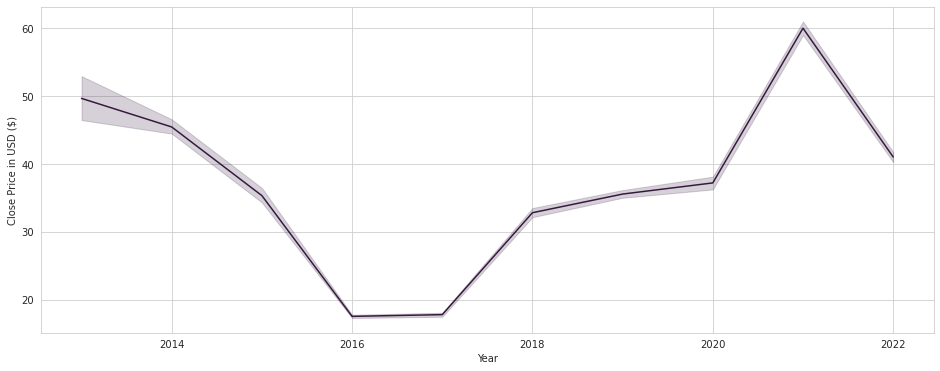

In [9]:
sns.set_style('whitegrid')
sns.set_palette("rocket")

plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='Year', y='Close')
plt.ylabel('Close Price in USD ($)')
plt.show()




## Volume of Sales

Volume is counted as the total number of shares that are actually traded (bought and sold) during the trading day or specified set period of time. It is a measure of the total turnover of shares.

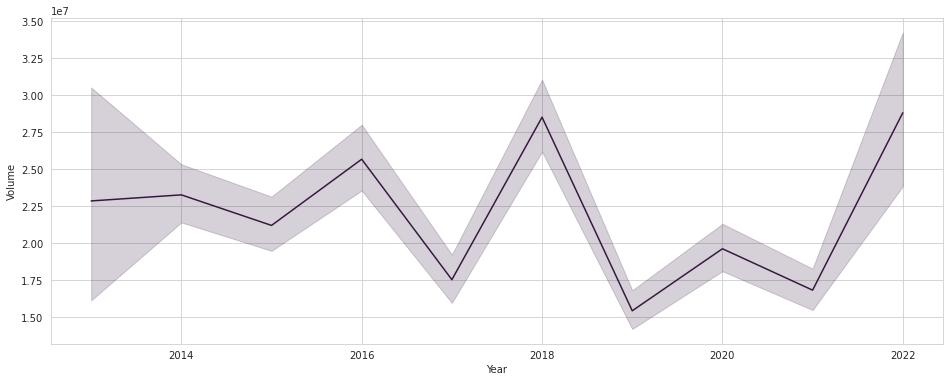

In [10]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='Year', y='Volume')
plt.show()


# 4. Predicting the current closing price stock price of Twitter

Thank you to [@faressayah](https://www.kaggle.com/faressayah) for this!

## Pulling the Current Twitter Stock Prices

In [11]:
yf.pdr_override()
# Get the current Twitter stock quote
df = pdr.get_data_yahoo('TWTR', start='2014-01-01', end=datetime.now())
# Show teh data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02 00:00:00-05:00,65.000000,67.500000,64.400002,67.500000,67.500000,29286655
2014-01-03 00:00:00-05:00,69.000000,70.430000,68.431999,69.000000,69.000000,33254610
2014-01-06 00:00:00-05:00,64.830002,66.870003,63.500000,66.290001,66.290001,27303649
2014-01-07 00:00:00-05:00,67.669998,67.730003,61.389999,61.459999,61.459999,31806111
2014-01-08 00:00:00-05:00,58.709999,61.259998,57.919998,59.290001,59.290001,27304350


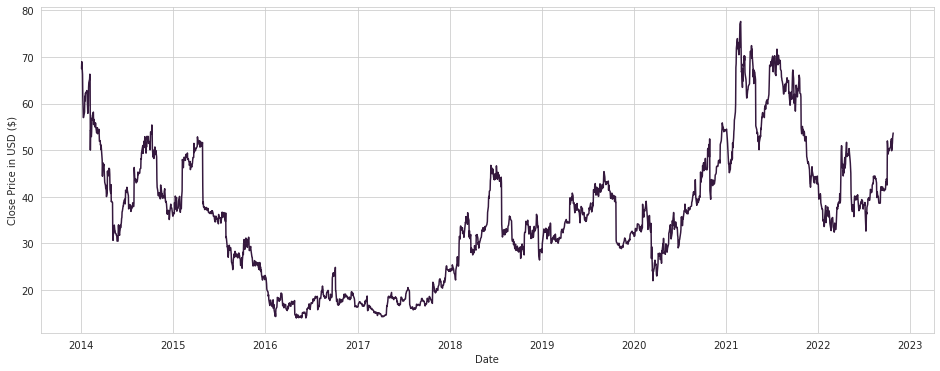

In [12]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x=df.index, y='Close')
plt.ylabel('Close Price in USD ($)')
plt.show()

## Preparing the Data 

In [13]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2111

## Scaling the Data

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.84077338],
       [0.86435087],
       [0.82175421],
       ...,
       [0.60939957],
       [0.61835901],
       [0.62386046]])

## Create the traing data set

In [15]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.84077338, 0.86435087, 0.82175421, 0.74583466, 0.71172592,
       0.67651683, 0.67573093, 0.68861995, 0.69475009, 0.74756369,
       0.73184536, 0.75746625, 0.76265327, 0.76123861, 0.76689722,
       0.75023583, 0.69003461, 0.72980196, 0.71424085, 0.77742853,
       0.79361839, 0.80540714, 0.82222575, 0.81672435, 0.56617416,
       0.63407734, 0.61160012, 0.62857595, 0.67337316, 0.66740024,
       0.68264697, 0.69427856, 0.65215344, 0.66991517, 0.65875511,
       0.65655455, 0.64366553, 0.6579692 , 0.65639739, 0.64287962,
       0.62401762, 0.63297706, 0.63454893, 0.64162219, 0.62118831,
       0.62668976, 0.62889032, 0.63643511, 0.62181706, 0.59588179,
       0.59792519, 0.58346436, 0.58519339, 0.56758881, 0.58016347,
       0.5463691 , 0.53237979, 0.47815155, 0.50785918, 0.52326313])]
[0.51336057006522]

[array([0.84077338, 0.86435087, 0.82175421, 0.74583466, 0.71172592,
       0.67651683, 0.67573093, 0.68861995, 0.69475009, 0.74756369,
       0.73184536, 0.75746625, 0.76265

## Build the LSTM Model

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-02-07 01:40:21.270747: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-07 01:40:21.965483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2051/2051 [==============================] - 92s 43ms/step - loss: 0.0020


## Creating the Test Data Set

In [17]:
# Create the testing data set 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1.8211903767416173

## Plot and Visualize the Data 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


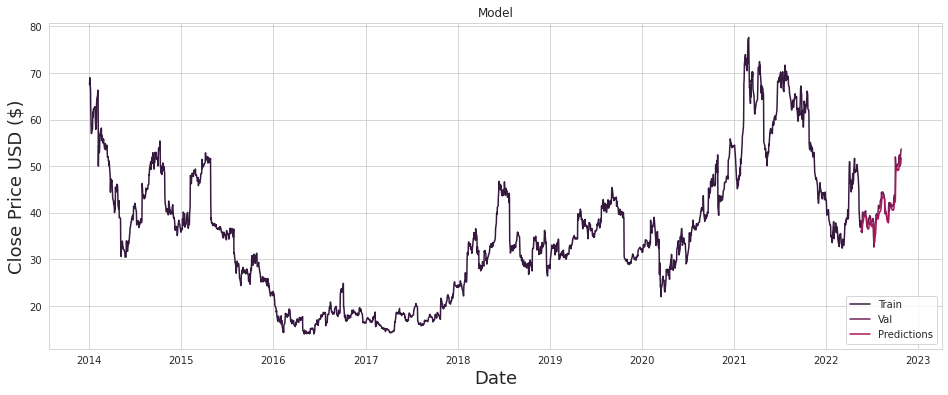

In [18]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


## Show the Valid and Predicted Prices

In [19]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2022-05-20 00:00:00-04:00,38.290001,36.008492
2022-05-23 00:00:00-04:00,37.860001,36.506115
2022-05-24 00:00:00-04:00,35.759998,37.009556
2022-05-25 00:00:00-04:00,37.160000,36.573738
2022-05-26 00:00:00-04:00,39.520000,36.504997
...,...,...
2022-10-21 00:00:00-04:00,49.889999,51.211956
2022-10-24 00:00:00-04:00,51.520000,50.558338
2022-10-25 00:00:00-04:00,52.779999,50.414528
